# ASO API Download

In [1]:
import os
import geopandas as gpd
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
import pandas as pd 
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import pyresample as prs
import requests
import json
import pprint
from rasterio.mask import mask
from mpl_toolkits.axes_grid1 import make_axes_locatable


# This is our functions module. We created several helper functions to discover, access, and harmonize the data below.
import tutorial_helper_functions as fn

### Identify Area of Interest and Time

Polygon coordinates to be used in search: -119.58958333333332,38.18625,-119.78652777777778,37.94041666666667,-119.42152777777777,37.86569444444444,-119.26041666666666,37.741527777777776,-119.19791666666666,37.88569444444445,-119.30930555555555,37.94625,-119.31097222222222,38.04486111111111,-119.58958333333332,38.18625


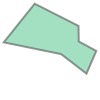

In [2]:
#polygon_filepath = str(os.getcwd() + '/tuo_rectangle.shp') # Note: A shapefile or other vector-based spatial data format could be substituted here.
polygon_filepath = ('/home/etboud/projects/data/shp_out/tuolumne.shp')
#polygon_filepath = ('/home/etboud/projects/Data/shp_out/tuo_rectangle.shp')
gdf = gpd.read_file(polygon_filepath) #Return a GeoDataFrame object

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
# Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
print('Polygon coordinates to be used in search:', polygon)
poly

In [3]:
temporal = '2013-05-25T00:00:00Z,2019-05-25T23:59:59Z' # Set temporal range

### Create Data Dictionary

In [4]:
# data_dict = { 'snowex': {'short_name': 'SNEX17_GPR','version': '2','polygon': polygon,'temporal':temporal},
#                 'aso': {'short_name': 'ASO_3M_SD','version': '1','polygon': polygon,'temporal':temporal},
#              'modis': {'short_name': 'MOD10A1','version': '6','polygon': polygon,'temporal':temporal}
#             }

In [4]:
data_dict = { 'aso': {'short_name': 'ASO_50M_SD','version': '1','polygon': polygon,'temporal':temporal}
            }

In [5]:
for k, v in data_dict.items(): fn.granule_info(data_dict[k])

There are 77 files of ASO_50M_SD version 1 over my area and time of interest.
The average size of each file is 20.92 MB and the total size of all 77 granules is 1610.75 MB


### Find Coincident

In [6]:
search_df = fn.time_overlap(data_dict)
print(len(search_df), ' total files returned')
date_avail = search_df['start_date']
date_avail

77  total files returned


0     2013-05-25T00:00:00.010Z
1     2013-06-01T00:00:00.010Z
2     2013-06-08T00:00:00.010Z
3     2014-03-23T00:00:00.010Z
4     2014-04-07T00:00:00.010Z
                ...           
72    2019-03-29T00:00:00.010Z
73    2019-04-17T00:00:00.010Z
74    2019-05-01T00:00:00.010Z
75    2019-05-02T00:00:00.010Z
76    2019-05-03T00:00:00.010Z
Name: start_date, Length: 77, dtype: object

### Data Access

In [7]:
# Create new dictionary with fields needed for CMR url search

url_df = search_df.drop(columns=['start_date', 'end_date','version','dataset_id'])
url_dict = url_df.to_dict('records')

# CMR search variables
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
headers= {'Accept': 'application/json'}

# Create URL list from each df row
urls = []
for i in range(len(url_dict)):
    response = requests.get(granule_search_url, params=url_dict[i], headers=headers)
    results = json.loads(response.content)
    urls.append(fn.cmr_filter_urls(results))
# flatten url list
urls = list(np.concatenate(urls))
urls

['https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.05.25/ASO_50M_SD_USCATB_20130525.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.05.25/ASO_50M_SD_USCATB_20130525.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.01/ASO_50M_SD_USCATB_20130601.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.01/ASO_50M_SD_USCATB_20130601.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.08/ASO_50M_SD_USCATB_20130608.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.08/ASO_50M_SD_USCATB_20130608.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.03.23/ASO_50M_SD_USCATB_20140323.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.03.23/ASO_50M_SD_USCATB_20140323.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.04.07/ASO_50M_SD_USCATB_20140407.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.04.07/ASO_50M_SD_USCATB

In [8]:
urls

['https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.05.25/ASO_50M_SD_USCATB_20130525.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.05.25/ASO_50M_SD_USCATB_20130525.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.01/ASO_50M_SD_USCATB_20130601.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.01/ASO_50M_SD_USCATB_20130601.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.08/ASO_50M_SD_USCATB_20130608.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2013.06.08/ASO_50M_SD_USCATB_20130608.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.03.23/ASO_50M_SD_USCATB_20140323.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.03.23/ASO_50M_SD_USCATB_20140323.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.04.07/ASO_50M_SD_USCATB_20140407.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_50M_SD.001/2014.04.07/ASO_50M_SD_USCATB

### Download

In [15]:
path = '/home/etboud/projects/data/aso'
#path = str(os.getcwd() + '/data/aso')
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)
fn.cmr_download(urls)
#fn.cmr_download(api_request)


# pull data from staged bucket for demonstration
#!awscliv2 --no-sign-request s3 cp s3://snowex-aso-modis-tutorial-data/ ./ --recursive #access data in staged directory

001/154: ASO_50M_SD_USCATB_20130525.tif
002/154: ASO_50M_SD_USCATB_20130525.tif.xml
003/154: ASO_50M_SD_USCATB_20130601.tif
004/154: ASO_50M_SD_USCATB_20130601.tif.xml
005/154: ASO_50M_SD_USCATB_20130608.tif
006/154: ASO_50M_SD_USCATB_20130608.tif.xml
007/154: ASO_50M_SD_USCATB_20140323.tif
008/154: ASO_50M_SD_USCATB_20140323.tif.xml
009/154: ASO_50M_SD_USCATB_20140407.tif
010/154: ASO_50M_SD_USCATB_20140407.tif.xml
011/154: ASO_50M_SD_USCATB_20140413.tif
012/154: ASO_50M_SD_USCATB_20140413.tif.xml
013/154: ASO_50M_SD_USCATB_20140420.tif
014/154: ASO_50M_SD_USCATB_20140420.tif.xml
015/154: ASO_50M_SD_USCATB_20140428.tif
016/154: ASO_50M_SD_USCATB_20140428.tif.xml
017/154: ASO_50M_SD_USCATB_20140502.tif
018/154: ASO_50M_SD_USCATB_20140502.tif.xml
019/154: ASO_50M_SD_USCATB_20140511.tif
020/154: ASO_50M_SD_USCATB_20140511.tif.xml
021/154: ASO_50M_SD_USCATB_20140517.tif
022/154: ASO_50M_SD_USCATB_20140517.tif.xml
023/154: ASO_50M_SD_USCATB_20140527.tif
024/154: ASO_50M_SD_USCATB_20140527.

In [16]:
aso_path = './ASO_3M_SD_USCATB_20130525.tif' # Define local filepath

aso = rasterio.open(aso_path)